<a href="https://colab.research.google.com/github/S23-S23/robot_programming/blob/main/%EA%B7%B8_%EB%A8%B8%EB%83%90_UWB_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

제박ㄹ 되게해주셍뇨

In [ ]:
!pip install pymap3d
import pymap3d as pm
import numpy as np

# 1. 기준 원점(Origin)의 위도, 경도, 고도 정의 (기존과 동일)
origin_lat = 36.728177
origin_lon = 127.443838
origin_alt = 67.405876

# 2. 변환할 목표 지점(사람)의 GPS 좌표 정의 (기존과 동일)
target_lat = 36.727938 # 목표 사람
target_lon = 127.443815
target_alt = 67.405876

# --- !!! 핵심 수정 사항: geodetic2enu -> geodetic2ned 로 변경 !!! ---
# NED 좌표계: North(북쪽)가 X축, East(동쪽)가 Y축, Down(아래)이 Z축
n, e, d = pm.geodetic2ned(target_lat, target_lon, target_alt,
                         origin_lat, origin_lon, origin_alt)

# NED 좌표계에 맞게 x, y를 할당합니다. (North -> x, East -> y)
x, y = n, e

print(f"변환된 로컬 좌표 (X, Y): ({x:.3f}, {y:.3f})")

# 다른 사람들도 동일하게 변환
other1_lat, other1_lon = 36.727927, 127.443762
n1, e1, _ = pm.geodetic2ned(other1_lat, other1_lon, target_alt, origin_lat, origin_lon, origin_alt)
x1, y1 = n1, e1
print(f"다른 사람 1의 로컬 좌표 (X, Y): ({x1:.3f}, {y1:.3f})")

other2_lat, other2_lon = 36.727939, 127.443902
n2, e2, _ = pm.geodetic2ned(other2_lat, other2_lon, target_alt, origin_lat, origin_lon, origin_alt)
x2, y2 = n2, e2
print(f"다른 사람 2의 로컬 좌표 (X, Y): ({x2:.3f}, {y2:.3f})")

# 4. 계산된 값으로 ground_truth_local 딕셔너리 채우기
ground_truth_local = {
    'Target Person': np.array([x, y]),
    'Other Person 1': np.array([x1, y1]),
    'Other Person 2': np.array([x2, y2]),
}

print("\n--- 최종 ground_truth_local (NED 기준) ---")
print(ground_truth_local)

변환된 로컬 좌표 (X, Y): (-26.523, -2.055)
다른 사람 1의 로컬 좌표 (X, Y): (-27.743, -6.789)
다른 사람 2의 로컬 좌표 (X, Y): (-26.412, 5.717)

--- 최종 ground_truth_local (NED 기준) ---
{'Target Person': array([-26.52272104,  -2.05456106]), 'Other Person 1': array([-27.74342959,  -6.78898534]), 'Other Person 2': array([-26.41174565,   5.7170394 ])}


with out MAE

--- Track to Ground Truth Matching (for labeling) ---
Track ID 0  =>  Matched with 'Other Person 1'
Track ID 1  =>  Matched with 'Other Person 1'
Track ID 2  =>  Matched with 'Other Person 1'
Track ID 3  =>  Matched with 'Other Person 1'
Track ID 4  =>  Matched with 'Other Person 1'
Track ID 5  =>  Matched with 'Other Person 1'
Track ID 6  =>  Matched with 'Other Person 1'
Track ID 7  =>  Matched with 'Other Person 1'
Track ID 8  =>  Matched with 'Other Person 1'
Track ID 9  =>  Matched with 'Target Person'

--- Mean Absolute Error (MAE) per Track (vs. last 5 positions average) ---
Track ID 0 ('Other Person 1'): 4.111 m
Track ID 1 ('Other Person 1'): 0.334 m
Track ID 2 ('Other Person 1'): 0.161 m
Track ID 3 ('Other Person 1'): 2.892 m
Track ID 4 ('Other Person 1'): 0.743 m
Track ID 5 ('Other Person 1'): 1.277 m
Track ID 6 ('Other Person 1'): 2.057 m
Track ID 7 ('Other Person 1'): 0.439 m
Track ID 8 ('Other Person 1'): 0.343 m
Track ID 9 ('Target Person'): 0.541 m


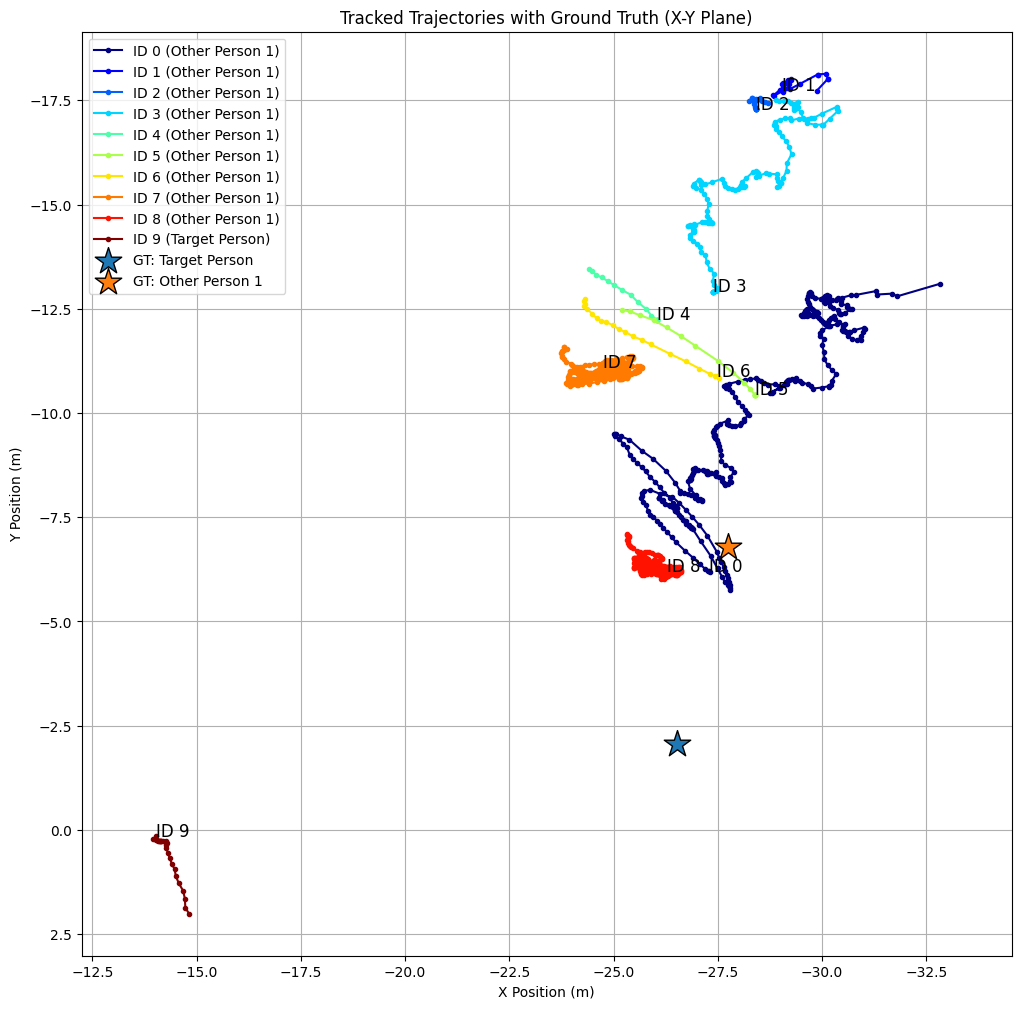

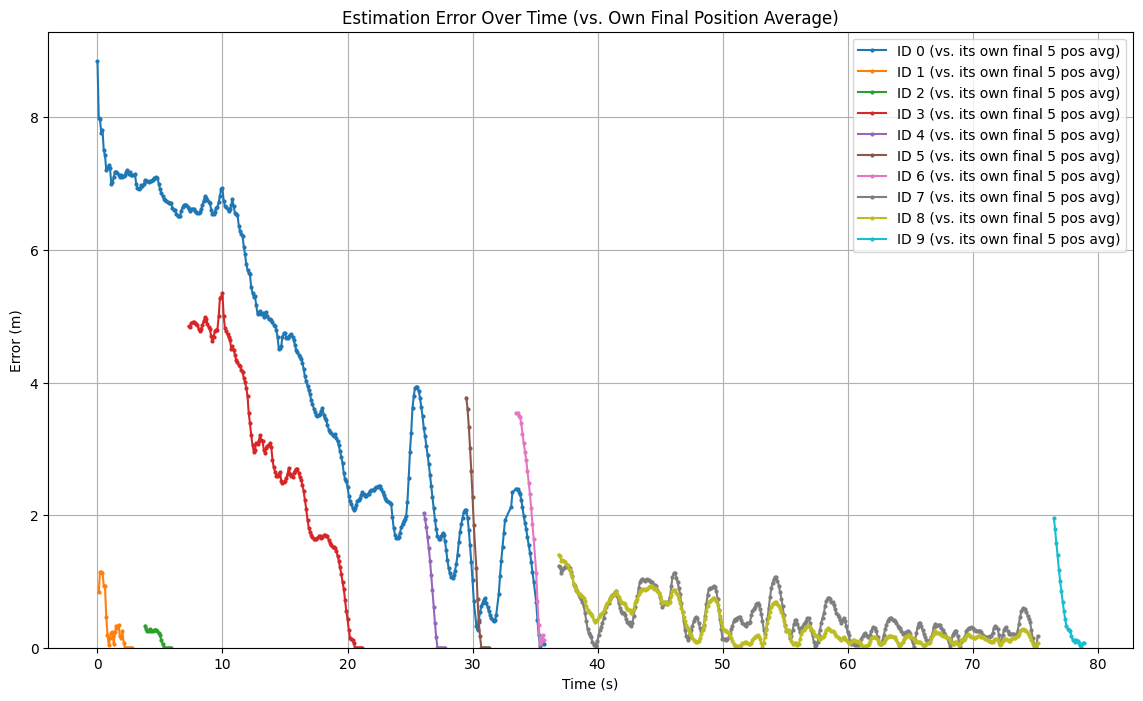

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# --- 1. Ground Truth(정답) 데이터 정의 ---
# 중요: 아래 X, Y 값은 GPS를 로컬 좌표계로 변환한 값이어야 합니다.
# 예시 값을 실제 변환된 값으로 수정해주세요.
ground_truth_local = {
    'Target Person': np.array([-26.52272104,  -2.05456106 ]),
    'Other Person 1': np.array([-27.74342959,  -6.78898534]),
    #'Other Person 2': np.array([-26.41174565,   5.7170394]),
}

# --- 사용자 설정: 마지막 몇 개의 포인트를 평균낼지 결정 ---
LAST_N_POINTS = 5

# --- 2. CSV 파일 읽기 ---
try:
    df = pd.read_csv('tracked_positions.csv')
    df['time_sec'] = df['timestamp'] - df['timestamp'].iloc[0]
except FileNotFoundError:
    print("tracked_positions.csv 파일을 찾을 수 없습니다. ROS 노드를 먼저 실행해주세요.")
    exit()

# --- 3. 각 트랙을 가장 가까운 GT와 자동으로 매칭 ---
# (이 부분은 시각화에서 어떤 트랙이 누구인지 구별하기 위해 그대로 사용합니다)
track_ids = df['track_id'].unique()
gt_labels = list(ground_truth_local.keys())
gt_positions = np.array(list(ground_truth_local.values()))

matches = {}
mean_errors = {}

print("--- Track to Ground Truth Matching (for labeling) ---")
for track_id in track_ids:
    track_data = df[df['track_id'] == track_id]
    # 트랙의 전체 평균 위치를 기반으로 매칭
    mean_track_pos = track_data[['x', 'y']].mean().values.reshape(1, 2)

    distances = cdist(mean_track_pos, gt_positions)
    closest_gt_index = np.argmin(distances)
    closest_gt_label = gt_labels[closest_gt_index]

    matches[track_id] = closest_gt_label
    print(f"Track ID {track_id}  =>  Matched with '{closest_gt_label}'")

# --- 4. Trajectories (X-Y Plane) 그래프에 GT 위치 표시 ---
plt.figure(figsize=(12, 12))
colors = plt.cm.jet(np.linspace(0, 1, len(track_ids)))

# 각 트랙의 궤적 그리기
for i, track_id in enumerate(track_ids):
    track_data = df[df['track_id'] == track_id]
    color = colors[i]
    # 매칭된 GT 라벨을 함께 표시
    gt_label = matches[track_id]
    plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=color, label=f'ID {track_id} ({gt_label})')
    plt.text(track_data['x'].iloc[-1], track_data['y'].iloc[-1], f'ID {track_id}', fontsize=12)

# GT 위치를 별 모양으로 그리기
for label, pos in ground_truth_local.items():
    plt.scatter(pos[0], pos[1], s=400, marker='*', label=f'GT: {label}', edgecolors='black', zorder=5)

plt.title('Tracked Trajectories with Ground Truth (X-Y Plane)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.gca().invert_xaxis() # X축 반전
plt.gca().invert_yaxis()
# plt.show() # 두 개의 그래프를 한번에 보기 위해 주석 처리


# --- 5. 시간에 따른 오차(Error) 그래프 그리기 (수정된 기준 적용) ---
plt.figure(figsize=(14, 8))

# 각 트랙의 마지막 N개 위치 평균을 새로운 기준으로 사용
for track_id, gt_label in matches.items():
    track_data = df[df['track_id'] == track_id].copy() # SettingWithCopyWarning 방지

    # 트랙 데이터가 N개보다 적을 경우, 전체 데이터의 평균을 사용
    num_points = min(LAST_N_POINTS, len(track_data))

    # --- 핵심 변경사항 ---
    # 각 트랙의 마지막 N개 위치의 평균을 계산하여 참조 위치(기준점)로 설정
    reference_pos = track_data.tail(num_points)[['x', 'y']].mean().values
    # --------------------

    # 추정된 위치와 참조 위치 사이의 유클리드 거리(오차) 계산
    estimated_pos = track_data[['x', 'y']].values
    errors = np.linalg.norm(estimated_pos - reference_pos, axis=1)

    # dataframe에 error 열 추가
    track_data['error'] = errors

    plt.plot(track_data['time_sec'], track_data['error'], marker='.', markersize=4, linestyle='-', label=f'ID {track_id} (vs. its own final {num_points} pos avg)')

    # 평균 절대 오차(MAE) 계산
    mae = track_data['error'].mean()
    mean_errors[track_id] = mae



# --- 6. 평균 오차 출력 (수정된 기준 적용) ---
print(f"\n--- Mean Absolute Error (MAE) per Track (vs. last {LAST_N_POINTS} positions average) ---")
for track_id, mae in sorted(mean_errors.items()):
    gt_label = matches[track_id] # 라벨링을 위해 매칭 정보 활용
    print(f"Track ID {track_id} ('{gt_label}'): {mae:.3f} m")

plt.title('Estimation Error Over Time (vs. Own Final Position Average)')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Y축은 0부터 시작
plt.show()

--- Track to Ground Truth Matching ---
Track ID 0  =>  Matched with 'Other Person 1'
Track ID 1  =>  Matched with 'Other Person 1'
Track ID 2  =>  Matched with 'Other Person 1'
Track ID 3  =>  Matched with 'Other Person 1'
Track ID 4  =>  Matched with 'Other Person 1'
Track ID 5  =>  Matched with 'Other Person 1'
Track ID 6  =>  Matched with 'Other Person 1'
Track ID 7  =>  Matched with 'Other Person 1'
Track ID 8  =>  Matched with 'Other Person 1'
Track ID 9  =>  Matched with 'Other Person 1'
Track ID 10  =>  Matched with 'Target Person'


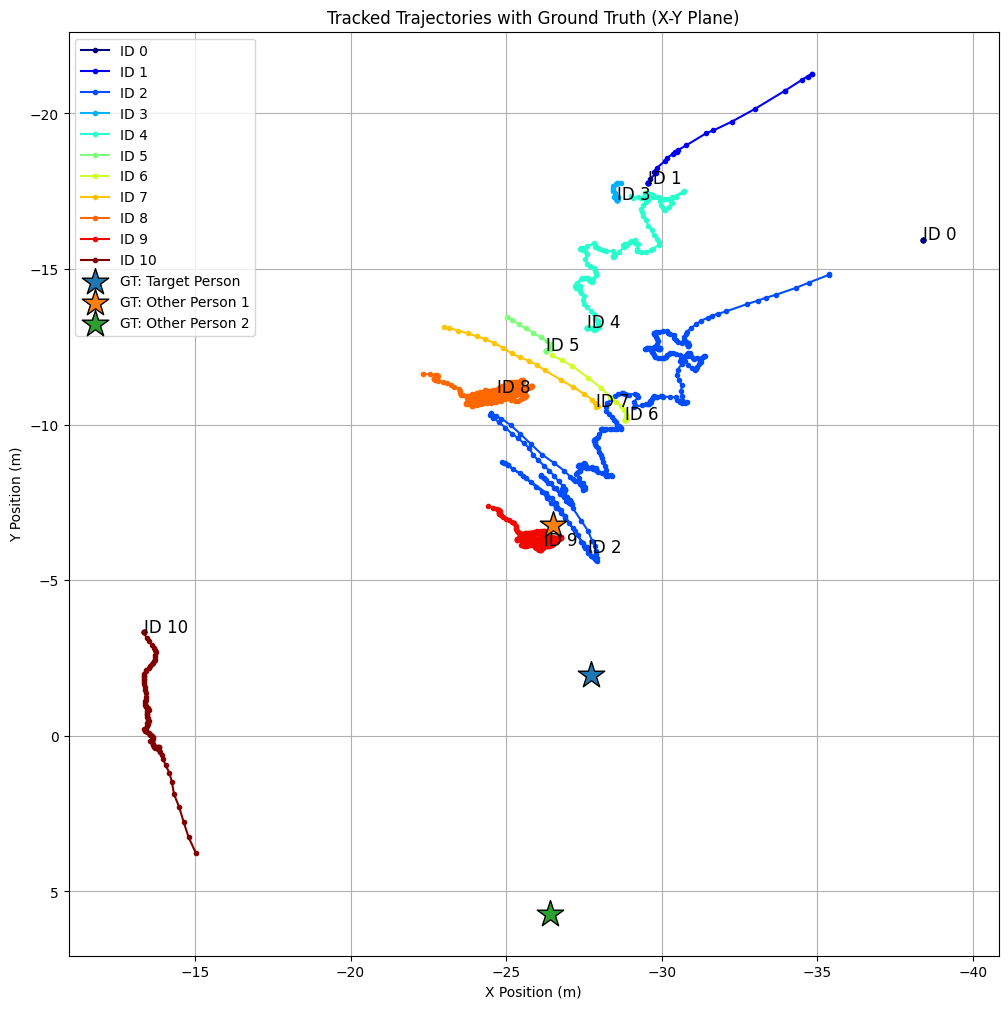


--- Mean Absolute Error (MAE) per Track ---
Track ID 0 (vs 'Other Person 1'): 15.005 m
Track ID 1 (vs 'Other Person 1'): 13.170 m
Track ID 2 (vs 'Other Person 1'): 4.146 m
Track ID 3 (vs 'Other Person 1'): 10.836 m
Track ID 4 (vs 'Other Person 1'): 9.044 m
Track ID 5 (vs 'Other Person 1'): 5.916 m
Track ID 6 (vs 'Other Person 1'): 4.441 m
Track ID 7 (vs 'Other Person 1'): 5.474 m
Track ID 8 (vs 'Other Person 1'): 4.634 m
Track ID 9 (vs 'Other Person 1'): 0.749 m
Track ID 10 (vs 'Target Person'): 14.248 m


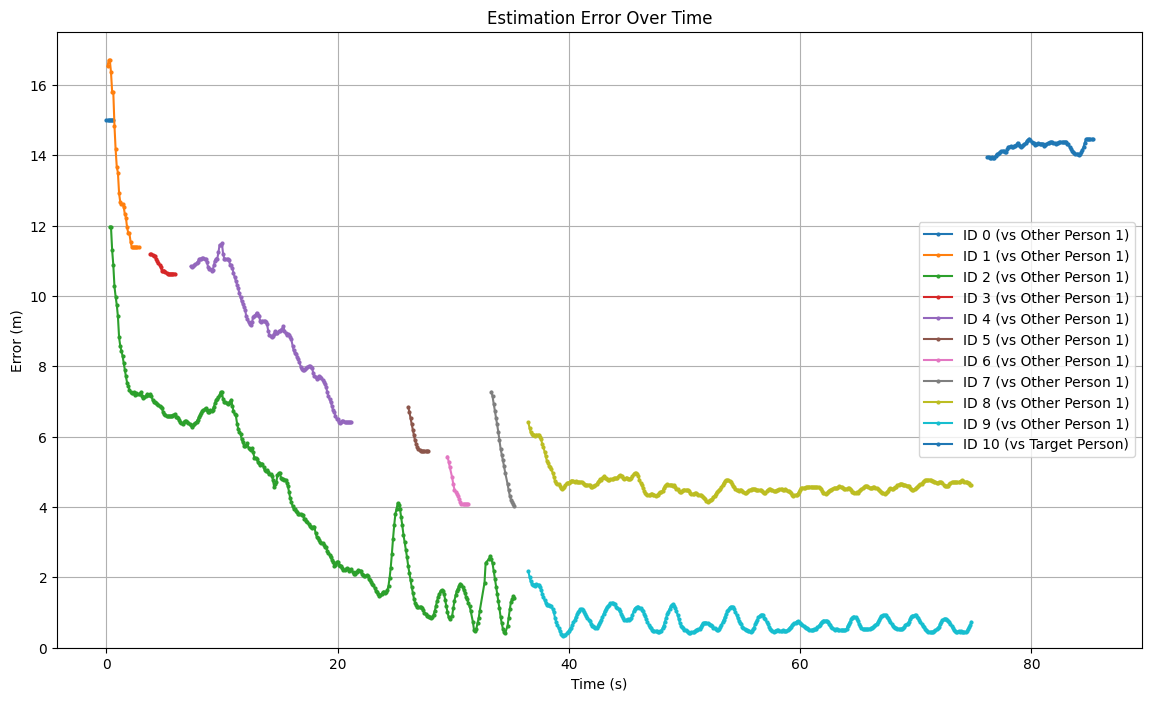

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# --- 1. Ground Truth(정답) 데이터 정의 ---
# 중요: 아래 X, Y 값은 GPS를 로컬 좌표계로 변환한 값이어야 합니다.
# 예시 값을 실제 변환된 값으로 수정해주세요.
ground_truth_local = {
    'Target Person': np.array([-27.74343205,  -1.9652326 ]),
    'Other Person 1': np.array([-26.52271859,  -6.78898437]),
    'Other Person 2': np.array([-26.41174565,   5.7170394]),
}

# --- 2. CSV 파일 읽기 ---
try:
    df = pd.read_csv('tracked_positions.csv')
    df['time_sec'] = df['timestamp'] - df['timestamp'].iloc[0]
except FileNotFoundError:
    print("tracked_positions.csv 파일을 찾을 수 없습니다. ROS 노드를 먼저 실행해주세요.")
    exit()

# --- 3. 각 트랙을 가장 가까운 GT와 자동으로 매칭 ---
track_ids = df['track_id'].unique()
gt_labels = list(ground_truth_local.keys())
gt_positions = np.array(list(ground_truth_local.values()))

matches = {}
mean_errors = {}

print("--- Track to Ground Truth Matching ---")
for track_id in track_ids:
    track_data = df[df['track_id'] == track_id]
    # 트랙의 평균 위치 계산
    mean_track_pos = track_data[['x', 'y']].mean().values.reshape(1, 2)

    # 가장 가까운 GT 찾기
    distances = cdist(mean_track_pos, gt_positions)
    closest_gt_index = np.argmin(distances)
    closest_gt_label = gt_labels[closest_gt_index]

    matches[track_id] = closest_gt_label
    print(f"Track ID {track_id}  =>  Matched with '{closest_gt_label}'")

# --- 4. Trajectories (X-Y Plane) 그래프에 GT 위치 표시 ---
plt.figure(figsize=(12, 12))
colors = plt.cm.jet(np.linspace(0, 1, len(track_ids)))

# 각 트랙의 궤적 그리기
for i, track_id in enumerate(track_ids):
    track_data = df[df['track_id'] == track_id]
    color = colors[i]
    plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=color, label=f'ID {track_id}')
    plt.text(track_data['x'].iloc[-1], track_data['y'].iloc[-1], f'ID {track_id}', fontsize=12)

# GT 위치를 별 모양으로 그리기
for label, pos in ground_truth_local.items():
    plt.scatter(pos[0], pos[1], s=400, marker='*', label=f'GT: {label}', edgecolors='black', zorder=5)

plt.title('Tracked Trajectories with Ground Truth (X-Y Plane)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
#plt.gca().invert_xaxis() # X축 반전
#plt.gca().invert_yaxis()
plt.show()


# --- 5. 시간에 따른 오차(Error) 그래프 그리기 ---
plt.figure(figsize=(14, 8))

for track_id, gt_label in matches.items():
    track_data = df[df['track_id'] == track_id].copy() # SettingWithCopyWarning 방지
    gt_pos = ground_truth_local[gt_label]

    # 추정된 위치와 실제 위치 사이의 유클리드 거리(오차) 계산
    estimated_pos = track_data[['x', 'y']].values
    errors = np.linalg.norm(estimated_pos - gt_pos, axis=1)

    # dataframe에 error 열 추가
    track_data['error'] = errors

    plt.plot(track_data['time_sec'], track_data['error'], marker='.', markersize=4, linestyle='-', label=f'ID {track_id} (vs {gt_label})')

    # 평균 절대 오차(MAE) 계산
    mae = track_data['error'].mean()
    mean_errors[track_id] = mae



# --- 6. 평균 오차 출력 ---
print("\n--- Mean Absolute Error (MAE) per Track ---")
for track_id, mae in sorted(mean_errors.items()):
    gt_label = matches[track_id]
    print(f"Track ID {track_id} (vs '{gt_label}'): {mae:.3f} m")

plt.title('Estimation Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Y축은 0부터 시작
plt.show()


# New Section

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# --- 1. Ground Truth(정답) 데이터 정의 ---
# 중요: 아래 X, Y 값은 GPS를 로컬 좌표계로 변환한 값이어야 합니다.
ground_truth_local = {
    'Target Person': np.array([-27.74342959,  -6.78898534]),
    'Other Person 1': np.array([-26.52272106,  -1.96523232]),
    #'Other Person 2': np.array([-26.41174565,   5.7170394]),
}

# --- 2. CSV 파일 읽기 ---
try:
    df = pd.read_csv('tracked_positions.csv')
    df['time_sec'] = df['timestamp'] - df['timestamp'].iloc[0]
except FileNotFoundError:
    print("tracked_positions.csv 파일을 찾을 수 없습니다. ROS 노드를 먼저 실행해주세요.")
    exit()

# --- 3. 모든 트랙 포인트를 'ID 0'으로 통합하여 오차 계산 (vs 'Other Person 1') ---
# 로직 변경: 모든 측정 포인트를 지정된 'Other Person 1' GT를 기준으로 오차를 계산합니다.
print("--- Calculating Errors for All Tracks against 'Other Person 1' ---")

# 기준이 될 Ground Truth('Other Person 1')의 위치를 가져옴
try:
    gt_target_pos = ground_truth_local['Other Person 1']
except KeyError:
    print("Error: 'Other Person 1' not found in ground_truth_local dictionary.")
    exit()

# 추적된 모든 위치들을 numpy 배열로 변환
estimated_positions = df[['x', 'y']].values

# 추정된 위치와 'Other Person 1'의 실제 위치 사이의 유클리드 거리(오차)를 계산
# np.linalg.norm은 벡터의 크기를 계산하며, 여기서는 두 점 사이의 거리를 의미함
errors = np.linalg.norm(estimated_positions - gt_target_pos, axis=1)

# 계산된 오차를 dataframe에 'error' 열로 추가
df['error'] = errors
print("Error calculation complete.")


# --- 4. Trajectories (X-Y Plane) 그래프 (ID 0으로 통합) ---
plt.figure(figsize=(12, 12))
unified_color = 'blue' # 모든 트랙에 적용할 단일 색상

# 범례(legend)에 'ID 0'이 한 번만 표시되도록 하기 위한 플래그
label_added = False

# 기존 track_id 별로 궤적을 그리되, 시각적 요소(색상, 레이블)를 통일
track_ids = df['track_id'].unique()
for track_id in track_ids:
    track_data = df[df['track_id'] == track_id]
    if not label_added:
        # 첫 번째 트랙을 그릴 때만 레이블을 추가
        plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=unified_color, label='ID 0 Trajectories')
        label_added = True
    else:
        # 이후 트랙은 레이블 없이 그림
        plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=unified_color)

    # 각 궤적의 끝에 원래 ID를 표시하여 경로 구분을 돕도록 함 (선택 사항)
    # plt.text(track_data['x'].iloc[-1], track_data['y'].iloc[-1], f'orig_id {track_id}', fontsize=9)


# GT 위치를 별 모양으로 그리기
for label, pos in ground_truth_local.items():
    plt.scatter(pos[0], pos[1], s=400, marker='*', label=f'GT: {label}', edgecolors='black', zorder=5)

plt.title('Unified Trajectories with Ground Truth')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.gca().invert_xaxis() # X축 반전
plt.gca().invert_yaxis()
plt.show()


# --- 5. 시간에 따른 오차(Error) 그래프 그리기 (ID 0으로 통합) ---
plt.figure(figsize=(14, 8))

# 모든 데이터 포인트의 오차를 시간에 따라 하나의 그래프로 그림
# 점이 많을 수 있으므로 정렬하여 그리는 것이 좋음
df_sorted = df.sort_values(by='time_sec')

plt.plot(df_sorted['time_sec'], df_sorted['error'], marker='.', markersize=4, linestyle='-', label='Error for ID 0 (All Tracks)')

plt.title('Estimation Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) # Y축은 0부터 시작
plt.show()


# --- 6. 전체 평균 오차(MAE) 출력 ---
# 데이터프레임의 'error' 열 전체의 평균을 계산
overall_mae = df['error'].mean()

print("\n--- Overall Mean Absolute Error (MAE) for ID 0 ---")
if not df.empty:
    print(f"Overall MAE (All Tracks vs Closest GTs): {overall_mae:.3f} m")
else:
    print("No error data to display.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# --- 1. Ground Truth(정답) 데이터 정의 ---
# 중요: 아래 X, Y 값은 GPS를 로컬 좌표계로 변환한 값이어야 합니다.
# 예시 값을 실제 변환된 값으로 수정해주세요.
ground_truth_local = {
    'Target Person': np.array([-27.74343205,  -1.9652326 ]),
    'Other Person 1': np.array([-26.52271859,  -6.78898437]),
    'Other Person 2': np.array([-26.41174565,   5.7170394]),
}

# --- 2. CSV 파일 읽기 ---
try:
    df = pd.read_csv('tracked_positions_good.csv')
    df['time_sec'] = df['timestamp'] - df['timestamp'].iloc[0]
except FileNotFoundError:
    print("tracked_positions.csv 파일을 찾을 수 없습니다. ROS 노드를 먼저 실행해주세요.")
    exit()

# --- 3. 각 트랙을 가장 가까운 GT와 자동으로 매칭 (MAE 계산용) ---
track_ids = df['track_id'].unique()
gt_labels = list(ground_truth_local.keys())
gt_positions = np.array(list(ground_truth_local.values()))

matches = {}
mean_errors = {}

print("--- Track to Ground Truth Matching ---")
for track_id in track_ids:
    track_data = df[df['track_id'] == track_id]
    mean_track_pos = track_data[['x', 'y']].mean().values.reshape(1, 2)
    distances = cdist(mean_track_pos, gt_positions)
    closest_gt_index = np.argmin(distances)
    closest_gt_label = gt_labels[closest_gt_index]
    matches[track_id] = closest_gt_label
    print(f"Track ID {track_id}  =>  Matched with '{closest_gt_label}'")

# --- 그룹 및 목표 GT 정의 ---
grouped_tracks = {
    'ID 0': {'tracks': [0, 4, 8, 10], 'gt_label': 'Target Person'},
    'ID 1': {'tracks': [1, 5], 'gt_label': 'Other Person 1'},
    'ID 2': {'tracks': [2, 7, 9], 'gt_label': 'Other Person 2'},
}

# 원래 track ID를 그룹 ID 이름으로 매핑
track_id_to_group_name = {}
for group_name, info in grouped_tracks.items():
    for original_id in info['tracks']:
        track_id_to_group_name[original_id] = group_name

# --- 4. Trajectories (X-Y Plane) 그래프에 GT 위치 표시 ---
plt.figure(figsize=(12, 12))

# 그룹별 색상을 더 명확하게 구분되는 색으로 변경
plot_colors = {
    'ID 0': 'blue',    # 파란색
    'ID 1': 'green',   # 초록색
    'ID 2': 'orange',  # 주황색
}

# 범례 중복을 피하기 위한 집합
plotted_labels = set()

# 각 트랙의 궤적 그리기
for original_id in track_ids:
    track_data = df[df['track_id'] == original_id]
    group_name = track_id_to_group_name.get(original_id)

    if group_name:
        color = plot_colors[group_name]
        label = group_name

        # 그룹당 한 번만 범례에 라벨 추가
        if label not in plotted_labels:
            plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=color, label=label)
            plotted_labels.add(label)
        else:
            plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', color=color)

        # ⭐ 변경점: 텍스트 색상을 검은색('black')으로 고정
        plt.text(track_data['x'].iloc[-1], track_data['y'].iloc[-1], f'{group_name}',
                 fontsize=12, color='black')
    else:
        # 그룹에 속하지 않은 트랙은 개별적으로 그림
        plt.plot(track_data['x'], track_data['y'], marker='.', linestyle='-', label=f'ID {original_id}')
        plt.text(track_data['x'].iloc[-1], track_data['y'].iloc[-1], f'ID {original_id}',
                 fontsize=12, color='black')

# GT 위치를 별 모양으로 그리기
for label, pos in ground_truth_local.items():
    plt.scatter(pos[0], pos[1], s=400, marker='*', label=f'GT: {label}', edgecolors='black', zorder=5)

plt.title('Tracked Trajectories with Ground Truth (X-Y Plane)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- 5. 시간에 따른 오차(Error) 그래프 그리기 ---
plt.figure(figsize=(14, 8))
all_errors = []

for group_name, info in grouped_tracks.items():
    group_tracks = info['tracks']
    gt_label = info['gt_label']
    gt_pos = ground_truth_local[gt_label]

    for original_id in group_tracks:
        track_data = df[df['track_id'] == original_id].copy()

        if not track_data.empty:
            estimated_pos = track_data[['x', 'y']].values
            errors = np.linalg.norm(estimated_pos - gt_pos, axis=1)
            track_data['error'] = errors

            # 그룹별로 지정된 색상으로 오차 그래프 그리기
            plt.plot(track_data['time_sec'], track_data['error'], marker='.', markersize=4, linestyle='-',
                     color=plot_colors[group_name])

            all_errors.extend(errors)

# 범례를 명확하게 다시 생성
legend_handles = [
    plt.Line2D([0], [0], color=plot_colors['ID 0'], lw=2, label=f'ID 0 (vs {grouped_tracks["ID 0"]["gt_label"]})'),
    plt.Line2D([0], [0], color=plot_colors['ID 1'], lw=2, label=f'ID 1 (vs {grouped_tracks["ID 1"]["gt_label"]})'),
    plt.Line2D([0], [0], color=plot_colors['ID 2'], lw=2, label=f'ID 2 (vs {grouped_tracks["ID 2"]["gt_label"]})')
]

plt.title('Estimation Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.legend(handles=legend_handles, loc='upper right')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

# --- 6. 평균 오차 출력 (Grouped MAE) ---
print("\n--- Mean Absolute Error (MAE) per Group ---")
for group_name, info in grouped_tracks.items():
    group_tracks = info['tracks']
    gt_label = info['gt_label']

    group_errors = []
    for original_id in group_tracks:
        track_data = df[df['track_id'] == original_id].copy()
        if not track_data.empty:
            gt_pos = ground_truth_local[gt_label]
            estimated_pos = track_data[['x', 'y']].values
            errors = np.linalg.norm(estimated_pos - gt_pos, axis=1)
            group_errors.extend(errors)

    if group_errors:
        group_mae = np.mean(group_errors)
        print(f"{group_name} (vs '{gt_label}'): {group_mae:.3f} m")
    else:
        print(f"{group_name} (vs '{gt_label}'): No data to calculate MAE.")

overall_mae = np.mean(all_errors) if all_errors else 0
print(f"\n--- Overall Mean Absolute Error (MAE) for all grouped tracks: {overall_mae:.3f} m ---")